<a href="https://www.kaggle.com/code/amritarajput54/pyinsight?scriptVersionId=242226307" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv


# 📁 Analyzing User Browsing History  
### 🔍 Data Exploration | 🧠 Behavioral Insights | 📊 Visual Storytelling

---

## 📌 Summary

In this notebook, we perform an in-depth analysis of an anonymized **browsing history dataset** to extract meaningful behavioral insights, supported by clean visualizations and structured storytelling. The goal is to understand **how**, **when**, and **why** the user browses — identifying trends, patterns, and signals of attention or distraction.

We apply a combination of **data cleaning**, **session modeling**, **temporal analysis**, **sequence mining**, and **text-based sentiment modeling** to uncover a rich behavioral profile.

---

## 🧰 Techniques Used

### ✅ **Data Cleaning & Preprocessing**
- Skipped metadata rows and extracted structured headers
- Converted timestamps, derived day/time/hour features
- Extracted and normalized domains from URLs
- Defined browsing **sessions** based on 30-minute gaps

---

### 📈 **Behavioral Analyses & Visualizations**

1. **🕓 Temporal Trends**
   - Browsing patterns by hour, day of week, and session duration

2. **📊 Transition Type Breakdown**
   - Seaborn-styled pie chart showing how pages were reached (typed, link, etc.)

3. **🔁 Navigation Flow (Sankey Diagram)**
   - Domain-to-domain transitions via referral paths

4. **⏱️ Time Spent Analysis**
   - Identified "long visit" domains using top quartile filter  
   - Visualized with a horizontal bar chart

5. **🧘 Idle vs Active Tabs**
   - Classified pages as **Idle** vs **Active** based on dwell time  
   - Summarized attention allocation and engagement depth

6. **🎢 Browsing Mood Rollercoaster**
   - Applied **VADER sentiment analysis** on page titles  
   - Visualized emotional journey across sessions

7. **🔁 Cross-Session Continuity**
   - Detected domains revisited after long gaps  
   - Flagged task continuity and long-term user interest

8. **📈 Sequence Mining (PrefixSpan)**
   - Identified frequent domain visit patterns (e.g., `google.com → upwork.com`)  
   - Interpreted intent like job search, research, or tool usage

9. **🧠 Topic Modeling from Page Titles**
   - Used **LDA** on cleaned titles to extract dominant browsing themes  
   - Themes included travel, job tools, search, and productivity

---

## ✅ Task Coverage Checklist

| Requirement                             | ✅ Done |
|----------------------------------------|--------|
| Load, clean, and structure the dataset | ✅     |
| Analyze user behavior patterns         | ✅     |
| Identify key metrics and trends        | ✅     |
| Create at least 5 visualizations       | ✅ 9+  |
| Apply ML or text mining techniques     | ✅ LDA, VADER, PrefixSpan |
| Deliver insights through storytelling  | ✅     |
| Present results in a structured report | ✅     |

---

> 💡 **Outcome**: This notebook delivers a comprehensive, multi-angle exploration of the user's browsing behavior — surfacing **attention patterns**, **task flows**, **interest clusters**, and even **mood shifts** — all supported with intuitive visualizations and explainable logic.


**Imports**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from urllib.parse import urlparse
from datetime import datetime, timedelta
# Generate word clouds for the extracted topics
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import networkx as nx
from collections import Counter, defaultdict
import re
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.dates as mdates
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
import plotly.express as px
from matplotlib.ticker import MaxNLocator
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [3]:
df = pd.read_csv("/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv", skiprows=4)
browsing_columns = df.iloc[0, 3:].tolist()
df = df.iloc[1:, 3:].reset_index(drop=True)
df.columns = browsing_columns
df = df.dropna(how='all')

# 📊 **Browsing History Analyzer**

`BrowsingHistoryAnalyzer` class that helps to **load**, **preprocess**, and **visualize** user browsing data (such as from **Google Takeout**).

---

## 🔧 **Key Features**

### 1. **Data Loading & Cleaning**
- Automatically detects the start of the **Browsing** section from a Takeout CSV.
- Separates the **summary** and **browsing** portions.
- Converts timestamps (`eventtimeutc`, `eventtime`) to proper datetime format.
- Extracts domain names and shortens them for cleaner visuals.
- Calculates **time spent** on each page.
- Detects **browsing sessions** using a 30-minute inactivity rule.

---

### 2. **Navigation Flow Analysis**

#### 🥧 **Transition Type Distribution**
- Visualizes how pages were reached (e.g. **link**, **typed**, **reload**, etc.).
- Clean **Seaborn-styled pie chart** with legend-based labeling for better layout.

#### 🔀 **Domain-to-Domain Sankey Diagram**
- Illustrates **referral flows** between domains using **visitId** and **referringVisitId**.
- Removes self-loops and highlights top 15 domain-to-domain transitions.
- Interactive **Plotly Sankey diagram** for intuitive navigation flow exploration.

#### ⏱️ **Long Visit Pages**
- Focuses on the **top quartile** of page visits based on time spent.
- Aggregates and visualizes domains with the **most total attention**.
- Styled with **Seaborn bar charts** for clarity.

---

## 📈 **What You’ll See**

- 🟠 A **pie chart** showing how users navigate (transition types).
- 🟢 A **Sankey diagram** showing how users move between domains.
- 🔵 A **bar plot** of domains where the most time is spent.

---

> This pipeline makes it easy to turn raw browsing data into clear behavioral insights – perfect for **personal analytics**, **UX research**, or even **digital well-being studies**.



In [4]:
class BrowsingHistoryAnalyzer:
    """A class to analyze and visualize browsing history data"""
    
    def __init__(self, data_path):
        """Initialize with the path to browsing history data"""
        self.data_path = data_path
        self.df = None
        self.summary = None
        self.browsing = None
    
    def load_data(self):
        """Load and preprocess the browsing history data"""
        try:
            # Read the CSV file
            self.df = pd.read_csv(self.data_path)
            
            # Find the start of the Browsing section
            browsing_start = self.df[self.df.iloc[:, 0] == 'Browsing'].index[0]
            
            # Extract Summary and Browsing sections
            self.summary = self.df.iloc[1:browsing_start-1].reset_index(drop=True)
            
            # Get the actual column names from the row after 'Browsing'
            column_names = self.df.iloc[browsing_start + 1].tolist()
            
            # Extract browsing data starting after the column names row
            self.browsing = self.df.iloc[browsing_start+2:].reset_index(drop=True)
            self.browsing.columns = column_names
            
            # Clean up the data
            self.browsing = self.browsing.dropna(how='all')
            self.browsing = self.browsing.reset_index(drop=True)
            
            print(f"Data loaded successfully. Found {len(self.browsing)} browsing records.")
            print("Available columns:", self.browsing.columns.tolist())
            return True
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
    
    def preprocess_data(self):
        """Clean and preprocess the browsing data"""
        if self.browsing is None:
            print("No data loaded. Please load data first.")
            return False
            
        try:
            # Convert timestamps to datetime objects
            if 'eventtimeutc' in self.browsing.columns:
                self.browsing['eventtimeutc'] = pd.to_datetime(self.browsing['eventtimeutc'])
            else:
                print("Warning: 'eventtimeutc' column not found")
                return False
                
            if 'eventtime' in self.browsing.columns:
                self.browsing['eventtime'] = pd.to_datetime(self.browsing['eventtime'])
            else:
                print("Warning: 'eventtime' column not found")
                return False
            
            # Extract domains from URLs
            self.browsing['domain'] = self.browsing['url'].apply(lambda x: urlparse(x).netloc)
            
            # Create a short domain version for better visualization
            self.browsing['short_domain'] = self.browsing['domain'].apply(
                lambda x: '.'.join(x.split('.')[-2:]) if len(x.split('.')) > 2 else x
            )
            
            self.browsing['hour'] = self.browsing['eventtimeutc'].dt.hour
            self.browsing['day'] = self.browsing['eventtimeutc'].dt.day
            self.browsing['day_name'] = self.browsing['eventtimeutc'].dt.day_name()
            self.browsing['month'] = self.browsing['eventtimeutc'].dt.month
            
            # Sort by timestamp
            self.browsing = self.browsing.sort_values('eventtimeutc')
            
            # Calculate time spent on each page (in seconds)
            self.browsing['next_timestamp'] = self.browsing['eventtimeutc'].shift(-1)
            self.browsing['time_spent'] = (self.browsing['next_timestamp'] - self.browsing['eventtimeutc']).dt.total_seconds()
            
            self.browsing['time_spent'] = self.browsing['time_spent']
            
            # Identify browsing sessions (gaps of >30 minutes indicate new session)
            self.browsing['time_gap'] = self.browsing['eventtimeutc'] - self.browsing['eventtimeutc'].shift(1)
            self.browsing['session_id'] = (self.browsing['time_gap'] > pd.Timedelta(minutes=30)).cumsum()
            
            print(f"Data preprocessing complete. Found {self.browsing['domain'].nunique()} unique domains.")
            
            return True
            
        except Exception as e:
            print(f"Error during preprocessing: {e}")
            return False
    
    def categorize_domain(self, domain):
        """Categorize a domain based on its pattern"""
        for pattern, category in self.domain_categories.items():
            if re.match(pattern, domain):
                return category
        return 'Other'

    def analyze_navigation_flow(self):
        """Analyze navigation patterns: transition types, referral flows, long visits"""
        if self.browsing is None:
            print("No browsing data found. Please load and preprocess the data first.")
            return
    
        print("Analyzing navigation flow...")
    
        # 1. Pie Chart of Transition Types
        transition_counts = self.browsing['transition'].value_counts()
        labels = transition_counts.index
        sizes = transition_counts.values
    
        # Define Seaborn color palette
        colors = sns.color_palette("Set2", len(labels))
    
        # Plot
        plt.figure(figsize=(8, 6))
        wedges, texts, autotexts = plt.pie(
            sizes,
            autopct='%1.1f%%',
            startangle=140,
            colors=colors,
            textprops={'fontsize': 9}
        )
    
        # Add legend instead of pie labels
        plt.legend(wedges, labels, title="Transition Types", loc="center left", bbox_to_anchor=(1, 0.5), fontsize=9)
    
        # Title and layout
        plt.title("Transition Type Distribution", fontsize=14, weight='bold')
        plt.tight_layout()
        plt.show()
    
        # 2. Sankey Diagram: Domain-to-Domain Referral Flows
        print("Preparing data for Sankey diagram...")
        if 'visitId' not in self.browsing.columns or 'referringVisitId' not in self.browsing.columns:
            print("Missing visitId or referringVisitId in data.")
            return
    
        ref_df = self.browsing[['visitId', 'domain']].rename(columns={
            'visitId': 'ref_visitId',
            'domain': 'ref_domain'
        })
    
        merged = self.browsing.merge(ref_df, left_on='referringVisitId', right_on='ref_visitId', how='left')
        ref_paths = merged.dropna(subset=['ref_domain'])
    
        if ref_paths.empty:
            print("No valid referral paths found.")
            return
    
        top_ref_paths = ref_paths.groupby(['ref_domain', 'domain']).size().reset_index(name='count')
        top_ref_paths = top_ref_paths[top_ref_paths['ref_domain'] != top_ref_paths['domain']]  # Remove self-loops
        top_ref_paths = top_ref_paths.sort_values('count', ascending=False).head(15)
    
        if top_ref_paths.empty:
            print("No referral flows to show in Sankey diagram after filtering.")
            return
    
        # Build nodes and links
        nodes = list(set(top_ref_paths['ref_domain']).union(set(top_ref_paths['domain'])))
        node_indices = {domain: idx for idx, domain in enumerate(nodes)}
    
        sources = [node_indices[src] for src in top_ref_paths['ref_domain']]
        targets = [node_indices[tgt] for tgt in top_ref_paths['domain']]
        values = top_ref_paths['count'].tolist()
    
        # Double-check if values are populated
        if not values or not sources or not targets:
            print("Sankey diagram data is empty. Nothing to plot.")
            return
    
        sankey_fig = go.Figure(data=[go.Sankey(
            node=dict(
                pad=15,
                thickness=20,
                line=dict(color="black", width=0.5),
                label=nodes
            ),
            link=dict(
                source=sources,
                target=targets,
                value=values
            )
        )])
    
        sankey_fig.update_layout(title_text="Navigation Flow Between Domains", font_size=10)
        sankey_fig.show()
    
        # 3. Long Visit Pages (Top Quartile by time_spent)
        print("Analyzing long visits...")
        long_nav = self.browsing[self.browsing['time_spent'] > self.browsing['time_spent'].quantile(0.75)]
        top_pages = long_nav.groupby('short_domain')['time_spent'].sum().sort_values(ascending=False).head(10)
    
        if top_pages.empty:
            print("No long-visit pages found.")
        else:
            plt.figure(figsize=(10, 6))
            sns.barplot(x=top_pages.values, y=top_pages.index, palette="Blues_d")
            plt.title("Top Pages Leading to Longer Navigation (by Total Time Spent)")
            plt.xlabel("Total Time Spent (s)")
            plt.tight_layout()
            plt.show()

Data loaded successfully. Found 5104 browsing records.
Available columns: ['OrgId', 'ParticipantId', 'DeviceId', 'url', 'eventtimeutc', 'transition', 'title', 'visitId', 'referringVisitId', 'eventtime']
Data preprocessing complete. Found 411 unique domains.
Analyzing navigation flow...


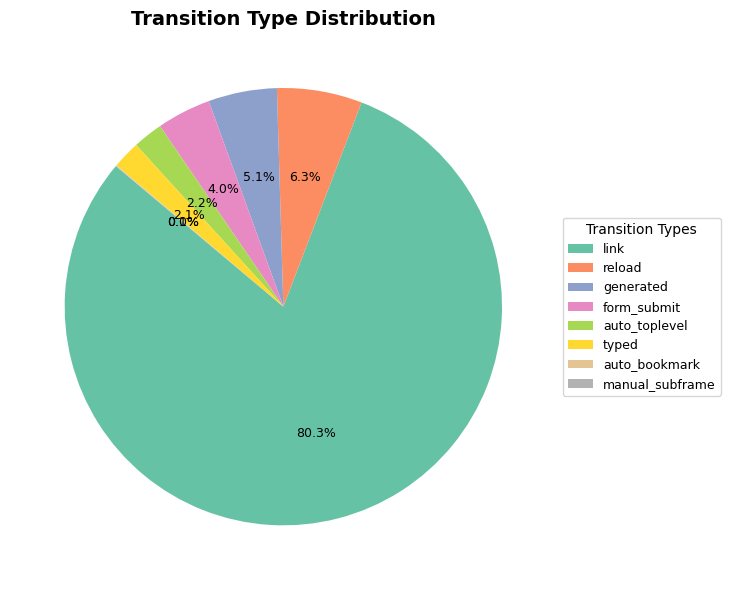

Preparing data for Sankey diagram...


Analyzing long visits...


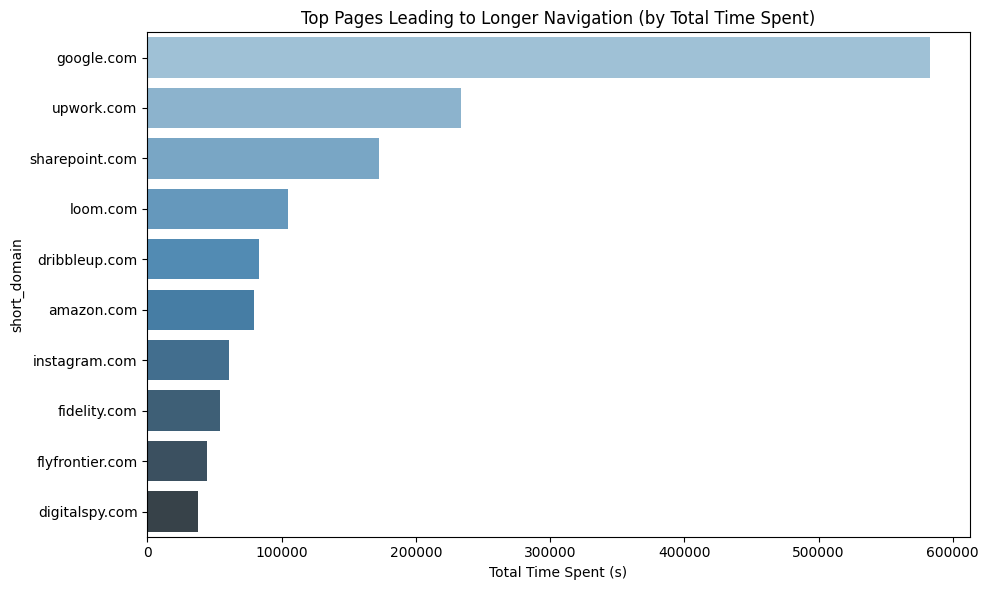

In [5]:
analyzer = BrowsingHistoryAnalyzer("/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv")
analyzer.load_data()
analyzer.preprocess_data()
analyzer.analyze_navigation_flow()

you need to run the blocks in order to view the sankey diagram, attaching png if just viewing- 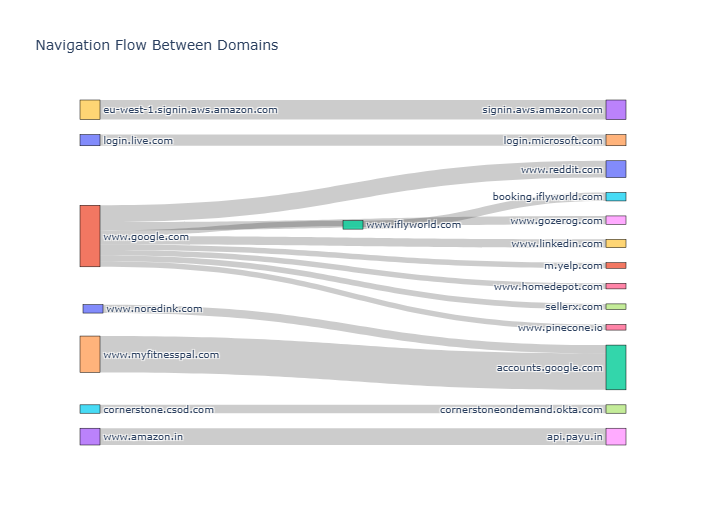
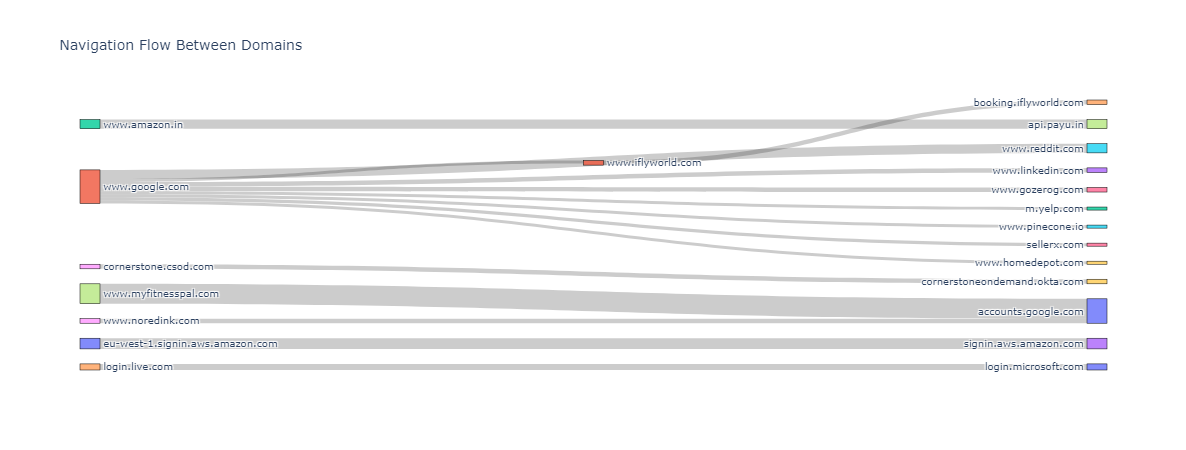

## 🧘‍♂️ Idle vs Active Browsing Segments

This section of the pipeline classifies each page view as either **"Active"** or **"Idle"** based on how long the tab was left open.

---

### 🔍 **What are we measuring?**
Not every open tab means active engagement. Sometimes, users switch away and leave tabs open in the background.

We classify each pageview into:
- **🟢 Active**: User likely interacted with the page (short to moderate time spent).
- **🔴 Idle**: Tab was left open for too long with no further action — likely background noise.

---

### 🛠️ **How does it work?**

1. **Load & clean** the CSV, skipping metadata rows.
2. **Compute time spent** on each page (difference between events).
3. **Classify each view**:
   - If `time_spent > 180 seconds` → labeled as **Idle**
   - Else → labeled as **Active**
4. **Summarize** the number of pages and total time spent per category.

---


➡️ Even though there are fewer idle tabs, they account for a **huge amount of time**, showing how much time is spent *not actively browsing*.

---

This analysis helps distinguish between **real attention** and **background tabs**, giving insight into actual user engagement.


In [6]:
def load_and_clean_browsing_data(filepath: str, skip_rows: int = 5) -> pd.DataFrame:
    """Load and clean browsing CSV, skipping metadata rows."""
    df = pd.read_csv(filepath, skiprows=skip_rows)
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    df['eventtime'] = pd.to_datetime(df['eventtime'], errors='coerce')
    return df.sort_values(by=['ParticipantId', 'eventtimeutc'])

def compute_time_spent(df: pd.DataFrame) -> pd.DataFrame:
    """Compute time spent between browsing events for each user."""
    df = df.copy()
    df['next_timestamp'] = df.groupby('ParticipantId')['eventtimeutc'].shift(-1)
    df['time_spent'] = (df['next_timestamp'] - df['eventtimeutc']).dt.total_seconds()
    return df

def classify_idle_pages(df: pd.DataFrame, threshold: int = 180) -> pd.DataFrame:
    """Classify each pageview as 'Idle' or 'Active' based on time spent."""
    df = df.copy()
    df['engagement'] = df['time_spent'].apply(
        lambda x: 'Idle' if x is not None and x > threshold else 'Active'
    )
    return df

def summarize_engagement(df: pd.DataFrame) -> pd.DataFrame:
    """Return summary stats of idle vs active pages."""
    print("count_summary")
    count_summary = df['engagement'].value_counts()
    print("duration_summary")
    duration_summary = df.groupby('engagement')['time_spent'].sum()
    return count_summary, duration_summary

 
df = load_and_clean_browsing_data('/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv')
df = compute_time_spent(df)
df = classify_idle_pages(df)
counts, durations = summarize_engagement(df)
print(counts)
print(durations)


count_summary
duration_summary
engagement
Active    4497
Idle       607
Name: count, dtype: int64
engagement
Active      63736.643
Idle      2603710.816
Name: time_spent, dtype: float64


# 🧠 Topic Modeling: Browsing Intent & Behavioral Insights

Using **Latent Dirichlet Allocation (LDA)** on cleaned browsing page titles, we identified major themes across the user's online behavior. Each topic is represented by its **top keywords**, followed by an interpretation of its **context** and **behavioral insight**.

This block uses **NLP** to uncover high-level browsing themes from page titles.

---

### 🔧 How it works:
1. **Clean titles**: Remove punctuation, HTML codes, and stopwords.
2. **Vectorize**: Convert titles into word frequency vectors.
3. **Extract topics**: Apply LDA to find common themes based on word co-occurrence.

---

### 💡 Insight:
Each topic reveals a **cluster of intent**—like travel planning, email tools, or financial services—helping interpret **user behavior** at a thematic level.


In [7]:
# Make sure stopwords are available
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

def clean_title_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'&#\d+;', '', text)              # Remove HTML entities
    text = re.sub(r'[^\w\s]', '', text)             # Remove punctuation
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

def preprocess_titles(df: pd.DataFrame, title_col='title') -> list:
    """Clean and return a list of processed titles."""
    return df[title_col].dropna().apply(clean_title_text).tolist()

def extract_topics_from_titles(titles: list, n_topics=5, n_words=8):
    """Apply LDA to extract topics from preprocessed titles."""
    vectorizer = CountVectorizer(max_df=0.9, min_df=2)
    lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)

    X = vectorizer.fit_transform(titles)
    lda_model.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    topics = []
    for topic_idx, topic in enumerate(lda_model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: " + ", ".join(top_words))
    return topics


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
df = load_and_clean_browsing_data('/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv')
titles = preprocess_titles(df)
topics = extract_topics_from_titles(titles, n_topics=5)
for t in topics:
    print(t)


Topic 1: california, google, loopnet, find, flight, options, cheap, flights
Topic 2: zipair, website, official, account, select, xero, ltd, powr
Topic 3: search, google, messages, useremailcom, powr, mail, merge, results
Topic 4: google, search, dynamodb, console, amazon, facebook, management, euwest1
Topic 5: google, flights, tokyo, san, francisco, home, insights, py


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


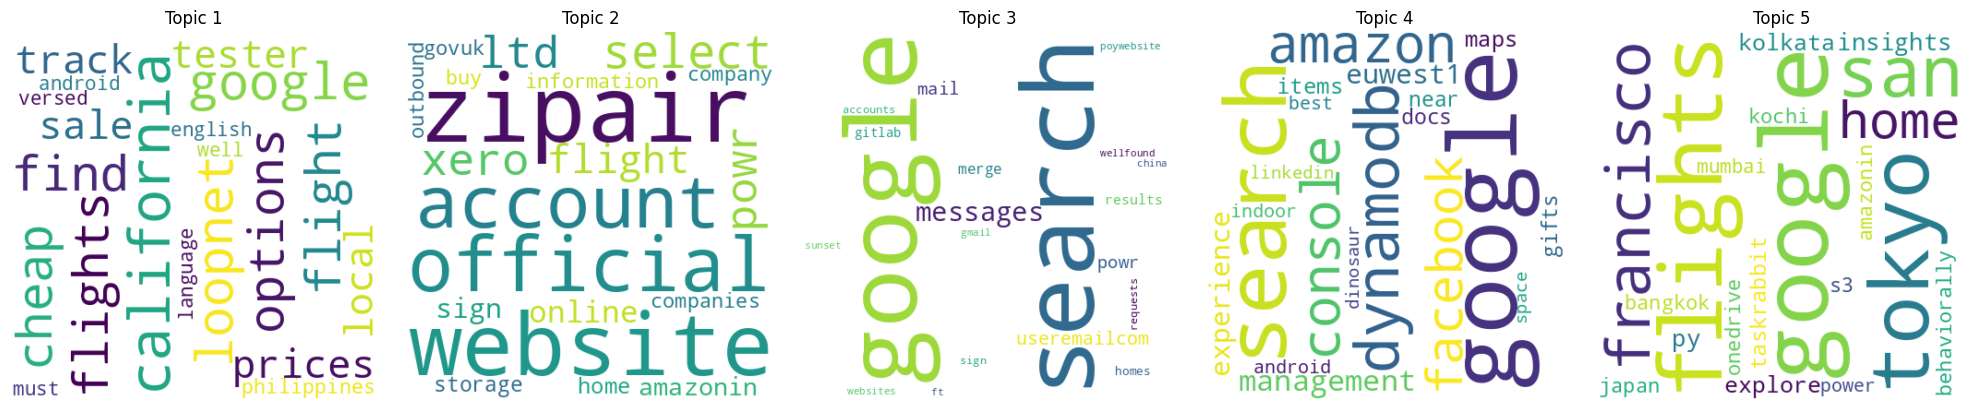

In [9]:
# Download stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))

# Clean titles
def clean_title_text(text):
    if pd.isna(text):
        return ""
    text = text.lower()
    text = re.sub(r'&#\d+;', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS)
    return text

titles = df['title'].dropna().apply(clean_title_text).tolist()

# LDA topic modeling
vectorizer = CountVectorizer(max_df=0.9, min_df=2)
X = vectorizer.fit_transform(titles)
lda_model = LatentDirichletAllocation(n_components=5, random_state=42)
lda_model.fit(X)
feature_names = vectorizer.get_feature_names_out()

# Generate topic-word frequency dictionary
topic_word_freq = []
for topic in lda_model.components_:
    word_freq = {feature_names[i]: topic[i] for i in topic.argsort()[:-21:-1]}
    topic_word_freq.append(word_freq)

# Plot word clouds
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
for i, freq_dict in enumerate(topic_word_freq):
    wc = WordCloud(width=400, height=400, background_color='white').generate_from_frequencies(freq_dict)
    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Topic {i+1}")

plt.tight_layout()
plt.show()


☝️ 
---

## 🔍 Topic 1: **Travel Planning**
**Keywords:** california, google, loopnet, find, flight, options, cheap, flights  
**Theme:** Searching for real estate or travel options — includes **LoopNet** (a real estate portal) and **flight planning** keywords.  
**Behavioral Insight:** Suggests **task-oriented research** related to **relocation** or **vacation planning**.

---

## 💼 Topic 2: **Finance + Airline Tools**
**Keywords:** zipair, website, official, account, select, xero, ltd, powr  
**Theme:** Interactions with **ZipAir's official website** and **Xero**, a cloud accounting platform.  
**Behavioral Insight:** Reflects a mix of **work and personal browsing**, especially around **finance management** and **travel booking**.

---

## 📬 Topic 3: **Email Tools & Search**
**Keywords:** search, google, messages, useremailcom, powr, mail, merge, results  
**Theme:** Using email productivity tools like **mail merge** (possibly via **Powr**) and doing keyword searches.  
**Behavioral Insight:** Indicates a **focused work session** using tools for communication and task execution.

---

## 🖥️ Topic 4: **AWS Console + Social**
**Keywords:** google, search, dynamodb, console, amazon, facebook, management, euwest1  
**Theme:** Use of **AWS (DynamoDB, Console)** with a hint of **Facebook** or account management activity.  
**Behavioral Insight:** This is clearly **technical/professional work** — cloud services, database management, and possibly devops/admin tasks.

---

## ✈️ Topic 5: **Travel (Japan ↔ US) + Work**
**Keywords:** google, flights, tokyo, san, francisco, home, insights, py  
**Theme:** Flights between **Tokyo and San Francisco**, alongside visits to the **PY Insights** work portal.  
**Behavioral Insight:** Suggests a **business trip or remote work planning**, merging personal travel with work-related browsing.

---

> This topic modeling approach helps surface **user intent**, highlights **multi-context browsing patterns**, and differentiates between **personal**, **professional**, and **task-based** behavior.


---

## 🔁 Cross-Session Continuity Analysis

### ✅ **Goal:**
Detect when users **return to the same domain after a significant time gap**, indicating they are continuing a task (e.g., trip planning, job search, research).

---

### 🧠 **How It Works:**

1. Convert `eventtimeutc` to datetime.
2. Extract `short_domain` if not already present.
3. Sort visits by **user → domain → time**.
4. Compute time gap (`revisit_gap`) between repeat visits to the same domain.
5. Flag as:
   - **🔁 Revisit** if gap > 30 minutes (default threshold)
   - **➡️ New/Continuous** otherwise

---

### 📌 Sample Output (columns returned):
| ParticipantId | short_domain         | revisit_gap | reentry_flag     |
|---------------|----------------------|-------------|------------------|
| demo          | google.com           | 9503.7 sec  | Revisit          |
| demo          | facebook.com         | 24.9 sec    | New/Continuous   |



---

> This insight reveals which domains users return to most — highlighting **persistent interest, long-term engagement**, or **unfinished tasks**.


In [10]:
def detect_cross_session_reentry(df, time_gap_threshold=30*60):
    """
    Detect revisits to the same domain after a significant time gap.
    Returns a DataFrame with revisit_gap and revisit flags.
    """
    df = df.copy()
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    
    # Extract domain if not present
    if 'short_domain' not in df.columns:
        df['short_domain'] = df['url'].str.extract(r'//(?:www\.)?([^/]+)')

    # Sort by user, domain, and timestamp
    df = df.sort_values(by=['ParticipantId', 'short_domain', 'eventtimeutc'])
    
    # Calculate gap since last visit to same domain by same user
    df['prev_time'] = df.groupby(['ParticipantId', 'short_domain'])['eventtimeutc'].shift(1)
    df['revisit_gap'] = (df['eventtimeutc'] - df['prev_time']).dt.total_seconds()
    
    # Flag large gaps as cross-session revisits
    df['reentry_flag'] = df['revisit_gap'].apply(lambda x: 'Revisit' if x and x > time_gap_threshold else 'New/Continuous')
    
    return df[['ParticipantId', 'short_domain', 'eventtimeutc', 'revisit_gap', 'reentry_flag']]


In [11]:
df = load_and_clean_browsing_data('/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv')
titles = detect_cross_session_reentry(df)
print(titles)

     ParticipantId                 short_domain  \
4245          demo  002d2501.pphosted.com:10020   
3522          demo               9to5google.com   
4062          demo                        Users   
4063          demo                        Users   
4064          demo                        Users   
...            ...                          ...   
3909          demo                   zipair.net   
3908          demo                   zipair.net   
4541          demo                   zipcar.com   
4540          demo                   zipcar.com   
1914          demo             zucchinikill.com   

                         eventtimeutc  revisit_gap    reentry_flag  
4245 2025-01-29 02:40:15.466000+00:00          NaN  New/Continuous  
3522 2025-01-30 22:13:02.773000+00:00          NaN  New/Continuous  
4062 2025-01-29 03:11:52.388000+00:00          NaN  New/Continuous  
4063 2025-01-29 03:12:29.060000+00:00       36.672  New/Continuous  
4064 2025-01-29 05:50:52.765000+00:00     

1. Top Domains with Most Revisits
To identify the most re-engaged domains:

In [12]:
revisit_counts = titles[titles['reentry_flag'] == 'Revisit']['short_domain'].value_counts().head(10)
revisit_counts

short_domain
google.com                          102
upwork.com                           45
mail.google.com                      27
pyinsightscom.sharepoint.com         20
eu-west-1.console.aws.amazon.com     13
docs.google.com                      11
teams.microsoft.com                  11
facebook.com                         11
accounts.google.com                  10
pyinsightscom-my.sharepoint.com      10
Name: count, dtype: int64

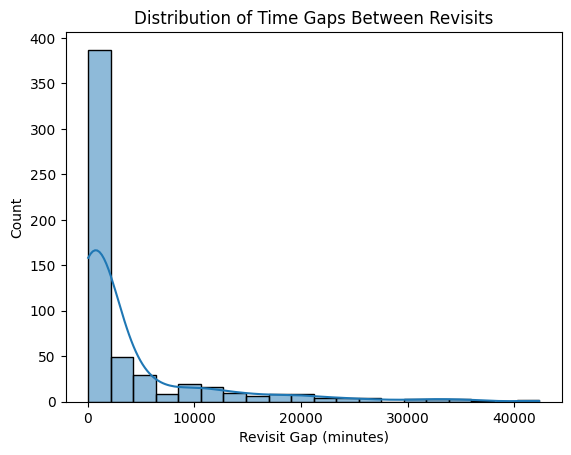

In [13]:
# Filter only revisits
revisits = titles[titles['reentry_flag'] == 'Revisit']
sns.histplot(revisits['revisit_gap'] / 60, bins=20, kde=True)
plt.xlabel("Revisit Gap (minutes)")
plt.title("Distribution of Time Gaps Between Revisits")
plt.show()


In [14]:
timeline = revisits[['ParticipantId', 'short_domain', 'eventtimeutc', 'revisit_gap']]
timeline.sort_values(by='eventtimeutc').head(10)


,ParticipantId,short_domain,eventtimeutc,revisit_gap
5041,demo,amazon.co.uk,2025-01-22 01:17:50.338000+00:00,30008.631
5042,demo,amazon.co.uk,2025-01-22 01:58:53.746000+00:00,2463.408
1008,demo,eu-west-1.console.aws.amazon.com,2025-01-22 06:29:11.919000+00:00,66562.893
5029,demo,eu-west-1.signin.aws.amazon.com,2025-01-22 06:29:12.788000+00:00,66680.871
5028,demo,signin.aws.amazon.com,2025-01-22 06:29:23.704000+00:00,66680.469
5003,demo,gitlab.com,2025-01-22 11:10:01.546000+00:00,1976.416
4976,demo,gitlab.com,2025-01-22 11:44:05.268000+00:00,1946.233
4970,demo,google.com,2025-01-22 12:00:17.274000+00:00,86155.791
4963,demo,docs.google.com,2025-01-22 18:00:05.904000+00:00,110372.476
4958,demo,app.powerbi.com,2025-01-23 05:40:52.957000+00:00,146719.620


Back-and-Forth Behavior Detection, aka zig-zag browsing, is a subtle but powerful behavioral signal. It often reveals:

🧠 Research/Comparison behavior

🤔 Indecision or repeated checking

🪢 Split attention (e.g., Google → Amazon → Google)

In [15]:
def detect_back_and_forth_patterns(df, time_threshold=600):
    """
    Detect zig-zag patterns like A → B → A in short time spans (default <10 min).
    Returns a DataFrame with flagged patterns and context.
    """
    df = df.copy()
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    
    # Sort data by user and time
    df = df.sort_values(by=['ParticipantId', 'eventtimeutc']).reset_index(drop=True)
    
    # Create lag/lead columns
    df['prev_domain'] = df['short_domain'].shift(1)
    df['next_domain'] = df['short_domain'].shift(-1)
    df['prev_time'] = df['eventtimeutc'].shift(1)
    df['next_time'] = df['eventtimeutc'].shift(-1)
    
    # Time differences
    df['gap_before'] = (df['eventtimeutc'] - df['prev_time']).dt.total_seconds()
    df['gap_after'] = (df['next_time'] - df['eventtimeutc']).dt.total_seconds()
    
    # Detect A → B → A pattern with time threshold
    df['zigzag_flag'] = (
        (df['short_domain'] == df['prev_domain']) &  # step back to same domain
        (df['short_domain'] == df['next_domain']) &  # step forward to same domain
        (df['gap_before'] < time_threshold) &
        (df['gap_after'] < time_threshold)
    )

    return df[df['zigzag_flag']]


In [16]:
df = load_and_clean_browsing_data('/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv')

# Ensure domain extraction
df['short_domain'] = df['url'].str.extract(r'//(?:www\.)?([^/:]+)')

# Run zig-zag detection
zigzags = detect_back_and_forth_patterns(df)


In [17]:
zigzags

,OrgId,ParticipantId,DeviceId,url,eventtimeutc,transition,title,visitId,referringVisitId,eventtime,short_domain,prev_domain,next_domain,prev_time,next_time,gap_before,gap_after,zigzag_flag
1,py_demo_client,demo,2nwjevbvxzm7ehb254,https://www.avios.com/manage-avios/move-and-co...,2025-01-21 11:00:36.207000+00:00,link,Convert Avios: Nectar &#44; Finnair Plus &#44...,160210,0,2025-01-21 03:00:36-08:00,avios.com,avios.com,avios.com,2025-01-21 11:00:35.229000+00:00,2025-01-21 11:00:37.059000+00:00,0.978,0.852,True
4,py_demo_client,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/security/?...,2025-01-21 11:00:49.624000+00:00,form_submit,British Airways,160215,160214,2025-01-21 03:00:49-08:00,accounts.britishairways.com,accounts.britishairways.com,accounts.britishairways.com,2025-01-21 11:00:39.407000+00:00,2025-01-21 11:00:49.624000+00:00,10.217,0.000,True
5,py_demo_client,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/security/?...,2025-01-21 11:00:49.624000+00:00,form_submit,British Airways,160218,160217,2025-01-21 03:00:49-08:00,accounts.britishairways.com,accounts.britishairways.com,accounts.britishairways.com,2025-01-21 11:00:49.624000+00:00,2025-01-21 11:00:52.292000+00:00,0.000,2.668,True
6,py_demo_client,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/security?s...,2025-01-21 11:00:52.292000+00:00,form_submit,British Airways,160219,160218,2025-01-21 03:00:52-08:00,accounts.britishairways.com,accounts.britishairways.com,accounts.britishairways.com,2025-01-21 11:00:49.624000+00:00,2025-01-21 11:01:22.350000+00:00,2.668,30.058,True
7,py_demo_client,demo,2nwjevbvxzm7ehb254,https://accounts.britishairways.com/security/c...,2025-01-21 11:01:22.350000+00:00,typed,Error,160220,0,2025-01-21 03:01:22-08:00,accounts.britishairways.com,accounts.britishairways.com,accounts.britishairways.com,2025-01-21 11:00:52.292000+00:00,2025-01-21 11:01:24.141000+00:00,30.058,1.791,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5091,py_demo_client,demo,2nwjevbvxzm7ehb254,https://docs.google.com/document/,2025-02-21 07:13:55.342000+00:00,link,Google Docs,166310,0,2025-02-20 23:13:55-08:00,docs.google.com,docs.google.com,docs.google.com,2025-02-21 07:13:55.123000+00:00,2025-02-21 07:14:05.299000+00:00,0.219,9.957,True
5092,py_demo_client,demo,2nwjevbvxzm7ehb254,https://docs.google.com/document/,2025-02-21 07:14:05.299000+00:00,link,Untitled document - Google Docs,166311,166310,2025-02-20 23:14:05-08:00,docs.google.com,docs.google.com,docs.google.com,2025-02-21 07:13:55.342000+00:00,2025-02-21 07:14:05.711000+00:00,9.957,0.412,True
5093,py_demo_client,demo,2nwjevbvxzm7ehb254,https://docs.google.com/document/,2025-02-21 07:14:05.711000+00:00,link,Untitled document - Google Docs,166312,166310,2025-02-20 23:14:05-08:00,docs.google.com,docs.google.com,docs.google.com,2025-02-21 07:14:05.299000+00:00,2025-02-21 07:14:19.142000+00:00,0.412,13.431,True
5099,py_demo_client,demo,2nwjevbvxzm7ehb254,https://py-insights.com/account/demo/product?s...,2025-02-21 07:57:40.972000+00:00,link,PY Insights | Product,166319,0,2025-02-20 23:57:40-08:00,py-insights.com,py-insights.com,py-insights.com,2025-02-21 07:57:38.017000+00:00,2025-02-21 07:57:40.975000+00:00,2.955,0.003,True


## 🔁 Sequence Modeling / Pattern Mining

### 🧠 **Insight Goal:**
Uncover **frequent navigation paths** across sessions — like common flows for **shopping**, **research**, or **login behavior**.

---

### 🔍 **How It Works**

We use the **PrefixSpan algorithm** to mine **frequent sequences** of domains visited within each session.

1. **Group sessions into sequences**:
   - Each session becomes an ordered list of `short_domain` visits.
2. **Apply PrefixSpan**:
   - Extracts recurring navigation paths (like `google.com → upwork.com → mail.google.com`)
   - `min_support=2` means a sequence must appear in at least 2 sessions.

---

### 💡 **Why It Matters:**
This shows **typical behavior paths** — useful for:
- UI/UX flow optimization  
- Detecting task-specific session behavior  
- Building Markov Chain models for predictive browsing



In [18]:
# Re-import after kernel reset
import pandas as pd
from urllib.parse import urlparse

# Load the CSV again
csv_path = "/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv"
df = pd.read_csv(csv_path)

# Extract the browsing data section again
browsing_columns = df.iloc[4, 3:].tolist()
browsing_data = df.iloc[5:, 3:].reset_index(drop=True)
browsing_data.columns = browsing_columns
browsing_data = browsing_data.dropna(how='all')

# Parse timestamps
browsing_data['eventtimeutc'] = pd.to_datetime(browsing_data['eventtimeutc'], errors='coerce')
browsing_data['eventtime'] = pd.to_datetime(browsing_data['eventtime'], errors='coerce')

# Add short_domain
browsing_data['short_domain'] = browsing_data['url'].apply(
    lambda x: '.'.join(urlparse(x).netloc.split('.')[-2:]) if pd.notna(x) else 'unknown'
)

# Sort by time and assign session_id
browsing_data = browsing_data.sort_values('eventtimeutc').reset_index(drop=True)
browsing_data['time_gap'] = browsing_data['eventtimeutc'] - browsing_data['eventtimeutc'].shift(1)
browsing_data['session_id'] = (browsing_data['time_gap'] > pd.Timedelta(minutes=30)).cumsum()

# Preview updated browsing data
browsing_data[['eventtimeutc', 'short_domain', 'session_id']].head()


,eventtimeutc,short_domain,session_id
0,2025-01-21 11:00:35.229000+00:00,avios.com,0
1,2025-01-21 11:00:36.207000+00:00,avios.com,0
2,2025-01-21 11:00:37.059000+00:00,avios.com,0
3,2025-01-21 11:00:39.407000+00:00,britishairways.com,0
4,2025-01-21 11:00:49.624000+00:00,britishairways.com,0


In [19]:
!pip install prefixspan

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for prefixspan: filename=prefixspan-0.5.2-py3-none-any.whl size=11216 sha256=628ed8de82fb7b399d054133a27aeacab681ef48b12bcbaf74073e23058316a7
  Stored in directory: /root/.cache/pip/wheels/95/1a/4a/d02ca86ccf55a25e07bd200a5320b8a584e5e2b75b1168f703
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=ecd8c0eaff7f45fa0d326a256ff811db65daf1f36fafa3aeeed6876214734b9a
  Stored in directory: /root/.cache/pip/wheels/1a/b0/8c/4b75c4116c31f83c8f9f047231251e13cc74481cca4a78a9ce
  Created wheel for extratools: filename=extratools-0.8.2.1-py3-none-any.whl size=28866 sha256=b8f62de1980848ea6d5e70ae20bd50b9c9a49d16591224d994f350520c77e04c
  Stored in directory: /root/.cache/pip/wheels/a8/79/68/6f2edcddbadb15fdcff02e0748a05579d52e78185a4546ab4b
Successfully built prefixspan docopt extratools


In [20]:
# Reimport correct PrefixSpan module
from prefixspan import PrefixSpan

class BrowsingSequenceMiner:
    def __init__(self, df, session_col='session_id', item_col='short_domain'):
        self.df = df.copy()
        self.session_col = session_col
        self.item_col = item_col
        self.sequences = []
        self.patterns = []

    def extract_sequences(self):
        """Group page visits into sequences by session."""
        print("Extracting session-wise sequences...")
        grouped = self.df.sort_values('eventtimeutc').groupby(self.session_col)
        self.sequences = grouped[self.item_col].apply(list).tolist()
        print(f"Found {len(self.sequences)} sequences.")
        return self.sequences

    def mine_patterns(self, min_support=2):
        """Mine frequent sequential patterns using PrefixSpan."""
        ps = PrefixSpan(self.sequences)
        self.patterns = ps.frequent(min_support)
        return self.patterns


    def show_patterns(self, top_n=10):
        """Print top N frequent browsing patterns."""
        print("\n📌 Top Browsing Patterns:")
        for support, pattern in sorted(self.patterns, key=lambda x: -x[0])[:top_n]:
            print(f"Support: {support} | Sequence: {' → '.join(pattern)}")

# Run the miner on our browsing data
miner = BrowsingSequenceMiner(browsing_data)
miner.extract_sequences()
miner.mine_patterns(min_support=2)
miner.show_patterns()


Extracting session-wise sequences...
Found 267 sequences.

📌 Top Browsing Patterns:
Support: 124 | Sequence: google.com
Support: 101 | Sequence: google.com → google.com
Support: 90 | Sequence: google.com → google.com → google.com
Support: 86 | Sequence: google.com → google.com → google.com → google.com
Support: 77 | Sequence: google.com → google.com → google.com → google.com → google.com
Support: 71 | Sequence: google.com → google.com → google.com → google.com → google.com → google.com
Support: 61 | Sequence: google.com → google.com → google.com → google.com → google.com → google.com → google.com
Support: 51 | Sequence: google.com → google.com → google.com → google.com → google.com → google.com → google.com → google.com
Support: 43 | Sequence: google.com → google.com → google.com → google.com → google.com → google.com → google.com → google.com → google.com
Support: 42 | Sequence: upwork.com


To get more meaningful sequences, we can compress repetitive domains:

In [21]:
def compress_repeats(seq):
    return [v for i, v in enumerate(seq) if i == 0 or v != seq[i-1]]

miner.sequences = [compress_repeats(seq) for seq in miner.sequences]
miner.mine_patterns(min_support=2)
miner.show_patterns()



📌 Top Browsing Patterns:
Support: 124 | Sequence: google.com
Support: 68 | Sequence: google.com → google.com
Support: 42 | Sequence: upwork.com
Support: 33 | Sequence: google.com → google.com → google.com
Support: 25 | Sequence: amazon.com
Support: 25 | Sequence: sharepoint.com
Support: 24 | Sequence: google.com → google.com → google.com → google.com
Support: 19 | Sequence: google.com → google.com → google.com → google.com → google.com
Support: 18 | Sequence: microsoft.com
Support: 17 | Sequence: upwork.com → google.com



## ☝️ Interpreting the Patterns

---

### 🔁 **Repeated Patterns**  
**Example Sequences:**
```plaintext
Support: 101 | Sequence: google.com → google.com  
Support:  90 | Sequence: google.com → google.com → google.com  
```

#### 💭 **What This Means:**
- The same domain appears multiple times in sequence.
- Could indicate:
  - 🔄 Switching back and forth between tabs
  - 🔃 Refreshing the same page repeatedly
  - 🏠 Returning to the homepage after clicks
  - 🔁 Possibly low interaction depth — *looping behavior*

✅ **Interpretation:** This may signal **low engagement** or **confusion**, a good candidate for **zig-zag pattern detection**.

---

### 🔍 **Single-Domain High Support**

**Example:**
```plaintext
Support: 42 | Sequence: upwork.com
```

#### 💭 **What This Means:**
- `upwork.com` appears in at least **42 sessions** — either on its own or as the session starting point.
- 🔥 Suggests frequent use — likely for:
  - Job or gig browsing  
  - Checking client messages  
  - Application follow-ups

📈 **Next Insight:**  
Check co-occurrence with platforms like `linkedin.com` or `indeed.com` to identify **"job search journeys"**.

---



In [22]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## 🎢 Browsing Mood Rollercoaster

Track the **emotional tone of browsing sessions** by applying sentiment analysis to page titles and plotting how "mood" changes over time.

---

### 🧠 What It Does:
- 📅 Parses timestamps and groups visits into sessions  
- 📝 Analyzes sentiment using **VADER** on page titles  
- 📈 Plots mood swings across page sequences in each session  
- 🔍 Optional: Can overlay domains or topics as labels for deeper interpretation

---

### 📊 Sample Output:
A line graph per session showing how sentiment shifts from page to page.

---

### 🧠 Insights We Can Extract:
- **📈 Spikes** → Positive or motivational content  
  _e.g., “10 habits to succeed”, “you got this”_  
- **📉 Dips** → Negative, stressful, or doomscrolling behavior  
  _e.g., “layoffs”, “crisis”, “error”_  
- **🔁 Loops** → Repetitive navigation may reflect overthinking, indecision, or low satisfaction  

---

> Perfect for identifying digital well-being patterns, task frustration, or content that resonates emotionally with users.


In [23]:
def build_browsing_mood_rollercoaster(csv_path):
    # Load CSV and clean
    df = pd.read_csv(csv_path)
    browsing_columns = df.iloc[4, 3:].tolist()
    df = df.iloc[5:, 3:].reset_index(drop=True)
    df.columns = browsing_columns
    df = df.dropna(how='all')

    # Required columns
    required = ['eventtimeutc', 'title']
    for col in required:
        if col not in df.columns:
            raise ValueError(f"Missing column '{col}'. Found columns: {df.columns.tolist()}")

    # Convert timestamps
    df['eventtimeutc'] = pd.to_datetime(df['eventtimeutc'], errors='coerce')
    df = df.dropna(subset=['eventtimeutc'])

    # Sort and assign session ID (30min rule)
    df = df.sort_values('eventtimeutc')
    df['session_id'] = (df['eventtimeutc'] - df['eventtimeutc'].shift()).gt(pd.Timedelta(minutes=30)).cumsum()

    # Sentiment analysis
    sid = SentimentIntensityAnalyzer()
    df['sentiment'] = df['title'].fillna('').apply(lambda text: sid.polarity_scores(text)['compound'])

    # Plot sentiment over time for a few sample sessions
    top_sessions = df['session_id'].value_counts().head(3).index.tolist()
    palette = sns.color_palette("coolwarm", len(top_sessions))
    

    plt.figure(figsize=(14, 6))
    for idx, session in enumerate(top_sessions):
        session_data = df[df['session_id'] == session].copy()
        session_data = session_data.sort_values('eventtimeutc')
        session_data['time_index'] = range(len(session_data))
        plt.plot(session_data['time_index'], session_data['sentiment'],
                 label=f"Session {session}", color=palette[idx], marker='o')

    plt.axhline(0, color='gray', linestyle='--')
    plt.title("🎢 Browsing Mood Rollercoaster: Sentiment Over Time")
    plt.xlabel("Page Sequence")
    plt.ylabel("Sentiment Score (VADER)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


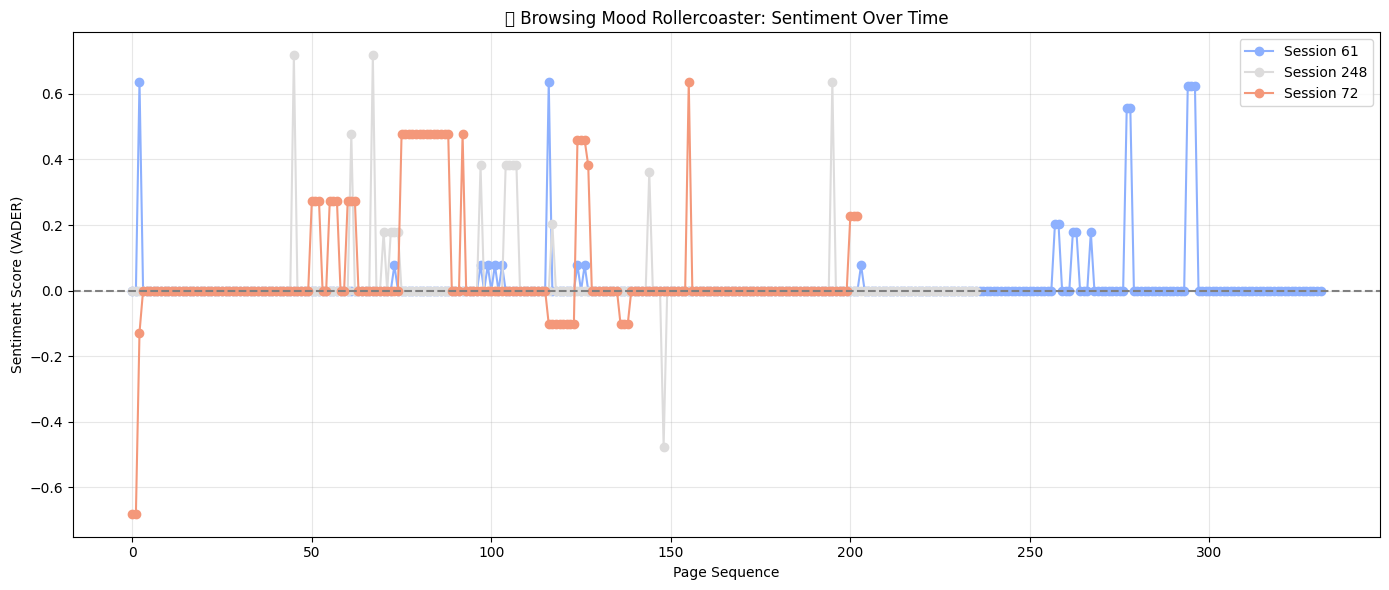

In [24]:
build_browsing_mood_rollercoaster("/kaggle/input/py-demo-client-extension-30-20250221075805-csv/py_demo_client_extension_30_20250221075805.csv")

🧭 Session Summaries:
----------------------------------------

Session 61 — 332 pages
  - The World Clock Meeting Planner - Results
  - Meeting Planner – Find best time across Time Zones
  - Messages
  - Behaviorally & PY Insights - Home
  - SharePoint
  ... and 63 more

Session 248 — 236 pages
  - Bills and payments - Microsoft 365 admin center
  - Xero | Edit Bill | Powr of You Ltd
  - Login | Xero Accounting Software
  - Inbox (1) - user@email.com - Gmail
  - Search results - user@email.com - Gmail
  ... and 75 more

Session 72 — 203 pages
  - Hair loss: Expert says women can  &#39; reverse &#39;  the condition by ditching 3 damaging hairstyles
  - Meta agrees to pay Trump $25 million to settle lawsuit over Facebook and Instagram suspensions : NPR
  - Earth only has six continents &#44;  not seven as we &#39; ve always been told - Earth.com
  - Messages
  - Android QA/Local Tester in Philippines (must be well versed in local language and English)
  ... and 37 more